# Malawi PMT Analysis Writeup

This notebook contains a description of the analysis of the Malawi PMT data. It describes the data cleaning process, the ML pipeline, and studies the performance of the model on the test set.

## Data Cleaning
I followed most all the steps in the guide, with a few exceptions:
1. I have a sophisticated outlier detection setup courtesy of Leo, but it doesn't currently remove any outliers. I manually remove Bobby Tables, but not Mr. Billionare as we discussed in Slack. I have currently commented out the outlier detection code because it takes a while to run and doesn't actually remove any outliers. 
2. I am not featurizing the shocks, food consumption, or the durable goods consumption as much as I could to match the survey instrument. This was done due to A. time constraints and B. the fact that we already have a LOT of features, and this really bogs down the forward stepwise OLS model. If anyone has suggestions on whether to pare down the set of variables we're using, I'm all ears. 
3. A point of confusion for me was that Leo suggested that I should log normalize most all of the continuous variables, whereas Emily suggested that I should min-max normalize them. I ended up min-max normalizing them, but I'm happy to change this if we have a consensus. 
4. I wasn't sure how to translate A44 to the LSMS variables. What I did was to take HH_MOD_F1, which seems to be about land ownership, and merged it to the LSMS data, giving a 1 if the household appeared in the HH_MOD_F1 table and a 0 otherwise. 
5. Something I didn't include, but wondered about, was the geographical variables that we have in the LSMS data. I didn't include them in the analysis, but I think they could be predictive, and we could hypothetically include them in the survey instrument since all it would require is a lat/long filled out by the enumerator which would let us merge to all the other geo variables. 
6. I think there are more sophisticated ways to featurize the roster. I basically just looked at the sex, age, education, etc. of the household head, but not the other members of the household. I did total up the cell phones, adults, children, and people though. 
7. For the R2 score by number of features, did you want R2 calculated on the training  set, the test set, or the validation set? I did it on the training set because that's what I believe I saw in your code.
8. Note that the way I'm doing the R^2 by number of features plot is a bit different than what you guys may have done in your code. Mine is dependent on the # of features that were eventually selected, so we have more observations in the lower number of obs than the upper. Thus the fall-off. I'm also only using a random subset of the variables available,  50 random ones + the intercept, because it becomes too computationally intensive to run otherwise. I think we could run it and get better results if we just let it run for a while, but I wanted to get something out quickly. 

Other than that, I followed the guide as far as I'm aware. 

## Setup

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple pages

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Function Appendix

In [13]:
def make_r2_by_feature_count_plot(dataset):
    # List of R^2 columns to process
    models = ["Stepwise", "RandomForest", "GradientBoosting", "Ridge"]
    r2_df = None
    for model in models:
        model_df = pd.read_csv(f"x02_ml_pipeline/output/{dataset}/r2_{model}.csv")
        # model_df = model_df.rename(columns={"Train R^2": f"{model} Train R^2", "Test R^2": f"{model} Test R^2"})
        model_df = model_df.drop(columns=["Selected Variables"])
        model_df['Model'] = model
        if r2_df is None:
            r2_df = model_df
        else:
            r2_df = pd.concat([r2_df, model_df], axis=0)
        
    r2_df.to_csv("temp.csv")    
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Define colors for each model
    colors = {
        "Stepwise": "#3366CC",
        "RandomForest": "#109618",
        "GradientBoosting": "#DC3912",
        "Ridge": "#990099"
    }
    
    # Plot each model's train and test R^2
    for model in models:
        model_data = r2_df[r2_df['Model'] == model]
        plt.plot(model_data["Number of Features"], model_data["Train R^2"], 
                 color=colors[model], label=f"{model} Train", linewidth=2)
        plt.plot(model_data["Number of Features"], model_data["Test R^2"], 
                 color=colors[model], label=f"{model} Test", linewidth=2, linestyle='--')
    
    # Customize the plot
    plt.xlabel("Number of Features")
    plt.ylabel("R^2 Score")
    plt.title(f"R^2 Scores by Number of Features for {dataset.capitalize()} Dataset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

def coalesce_vars(df, col_name_prefix):
    selected_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    df[col_name_prefix] = df[selected_cols].bfill(axis=1).iloc[:, 0]
    df = df.drop(columns=selected_cols)
    return df

def pretty_print_fi_table(fi_df):
    fi_df["fi_values"] = fi_df["fi_values"].apply(abs)
    # Determine the maximum number of features
    max_vars = fi_df["num_vars"].max()
    
    # Define the steps we want to show (5, 10, 15, 20, ...)
    steps = np.arange(5, max_vars + 1, 5)
    
    # If the max number of variables is not in steps, add it
    if max_vars not in steps:
        steps = np.append(steps, max_vars)
    
    # Create a new DataFrame to store the results
    result = pd.DataFrame(index=fi_df.columns)
    
    sub_dfs = []
    for step in steps:
        # Get the rows for this number of variables
        sub_df = fi_df[fi_df["num_vars"] == step]
        
        # Sort variables by importance
        sub_df = sub_df.sort_values(by="fi_values", ascending=False)
        sub_df = sub_df.rename(columns={"fi_values": f"Importance ({step})", "var_names": f"Variable ({step})", "num_vars": f"num_vars ({step})"})
        sub_dfs.append(sub_df)
    
    result = pd.concat(sub_dfs, axis=1)
    result = coalesce_vars(result, "Variable")
    result = coalesce_vars(result, "num_vars")

    result.index = result["Variable"]
    def combine_rows(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan
    collapsed_df = result.groupby(level=0).agg(combine_rows)
    collapsed_df = collapsed_df.sort_values(by=f"Importance ({max_vars})", ascending=False)
    collapsed_df = collapsed_df.drop(columns=["Variable", "num_vars"])
    collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)
    return collapsed_df

def round_helper(x):
    try:
        return round(float(x), 3)
    except:
        return x

def pretty_print_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    df["mean"] = df["mean"].apply(round_helper)
    df["std"] = df["std"].apply(round_helper)
    df["Missing Fraction before Imputation/Dummying"] = df["Missing Fraction before Imputation/Dummying"].apply(round_helper)
    column_mapping = {
        "hh_f05": "Age of dwelling",
        "hh_f10": "Number of rooms",
        "hh_f34": "Number of cell phones",
        "hh_h02a": "Number of days in last seven relied on less preferred food",
        "hh_h02b": "Number of days in last seven limited portion size",
        "hh_h02c": "Number of days in last seven reduced number of meals",
        "hh_h02d": "Number of days in last seven restricted consumption for adults",
        "hh_h02e": "Number of days in last seven restricted borrowed food",
        "hh_h03a": "Meals per day",
        "hh_h03b": "Meals per day (children 5-17)",
        "hh_h03c": "Meals per day (children 6-59 months)"
    }
    df["covariate"] = df["covariate"].apply(lambda x: column_mapping.get(x, x))
    df.set_index("covariate", inplace=True)
    return df

## Summary Tables

### All Data

In [14]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014.0,0.000,0.000
hh_wgt,502.734,260.338,0.000
outcome,2.403,2.665,0.000
hhid,0004806a172546e99ae07674de291ed7,0.000,0.000
pid,1.02,0.219,0.000
durable_asset_Air conditioner,0.001,0.040,0.000
durable_asset_Bed,0.548,1.055,0.000
durable_asset_Beer-brewing drum,0.018,0.179,0.000
durable_asset_Bicycle,0.415,0.649,0.000


### Rural Data


In [15]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_rural.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014.0,0.000,0.000
hh_wgt,510.518,266.904,0.000
outcome,2.015,1.681,0.000
hhid,0004806a172546e99ae07674de291ed7,0.000,0.000
pid,1.019,0.230,0.000
durable_asset_Air conditioner,0.0,0.023,0.000
durable_asset_Bed,0.374,0.791,0.000
durable_asset_Beer-brewing drum,0.018,0.171,0.000
durable_asset_Bicycle,0.434,0.649,0.000


### Urban Data

In [16]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_urban.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101201220032.0,0.000,0.000
hh_wgt,462.562,219.050,0.000
outcome,4.406,4.936,0.000
hhid,0034c13e91014cb0b1daf791fdea88be,0.000,0.000
pid,1.022,0.157,0.000
durable_asset_Air conditioner,0.006,0.085,0.000
durable_asset_Bed,1.449,1.629,0.000
durable_asset_Beer-brewing drum,0.018,0.216,0.000
durable_asset_Bicycle,0.316,0.638,0.000


## ML Pipeline

### ML Results

#### All Data

##### Ridge Regression

In [17]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_Ridge.csv', index_col=0)
df

,spearman,pearson,Train R^2,Test R^2,Selected Variables
0,0.796907,0.73908,0.584035,0.528115,"['hhsize', 'durable_asset_Bed', 'hh_f12_GAS', 'hh_f12_ELECTRICITY', 'durable_asset_Car', 'hh_f12_CHARCOAL', 'hh_h03a', 'hh_f41_Flush to septic tank', 'hh_head_education_5', 'hh_t05', 'hh_f09_SMOOTHED MUD', 'region_North', 'durable_asset_Iron (for pressing clothes)', 'hh_head_education_7', 'durable_asset_Desk', 'hh_f19_YES', 'hh_head_has_cellphone_2', 'hh_t01_It was more than adequate for household needs', 'durable_asset_Computer equipment & accessories', 'hh_h03b', 'durable_asset_Chair', 'durable_asset_Air conditioner', 'hh_h02a', 'hh_f01_EMPLOYER PROVIDES', 'hh_f07_BURNT BRICKS', 'hh_f41_Flush to piped sewer system', 'durable_asset_Mini-bus', 'hh_f43_RUBBISH PIT', 'hh_f05', 'durable_asset_Solar panel', 'hh_head_education_4', 'durable_asset_Lantern (paraffin)', 'num_adults', 'durable_asset_Motorcycle / Scooter', 'hh_f09_SMOOTH CEMENT', 'hh_f08_IRON SHEETS', 'hh_f07_OTHER (SPECIFY)', 'hh_t04_It was more than adequate for household needs', 'hh_h03c', 'hh_f11_COLLECTED FIREWOOD', 'hh_f08_GRASS', 'durable_asset_Beer-brewing drum', 'hh_head_sex_2', 'region_Central', 'hh_f12_COLLECTED FIREWOOD', 'durable_asset_Electric Kettle', 'hh_t01_It was less than adequate for household needs', 'hh_t02_It was less than adequate for household needs', 'hh_head_age', 'hh_f41_4_YES', 'hh_f10', 'hh_f36_PIPED INTO YARD/PLOT', 'durable_asset_Cupboard, drawers, bureau', 'hh_head_education_10', 'hh_f41_Hanging toilet / Hanging latrine', 'hh_f11_GRASS', 'hh_f41_Pit latrine without slab /Open pit', 'hh_f34', 'hh_f43_BURNING', 'hh_h02e', 'hh_f08_PLASTIC SHEETING', 'hh_f41_Flush to open drain', 'hh_f11_OTHER(SPECIFY)', 'durable_asset_Coffee table (for sitting room)', 'hh_f09_OTHER(SPECIFY)', 'hh_f11_PARAFFIN', 'hh_h02d', 'hh_f08_CONCRETE', 'hh_f07_COMPACTED EARTH(YAMDINDO)', 'num_phones', 'region_South']"


In [18]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_Ridge.csv', index_col=0)
pretty_print_fi_table(fi)


/data/tmp/ipykernel_1892623/3872247229.py:88: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)


,Importance (5),Importance (10),Importance (15),Importance (20),Importance (25),Importance (30),Importance (35),Importance (40),Importance (45),Importance (50),Importance (55),Importance (60),Importance (65),Importance (70),Importance (71)
Variable,,,,,,,,,,,,,,,
durable_asset_Air conditioner,,,,,186.217,188.6,199.759,200.513,206.232,201.415,206.458,205.932,208.118,208.339,208.339
durable_asset_Desk,,,180.826,149.931,147.28,149.751,152.013,154.981,160.403,159.76,157.937,158.788,159.508,159.339,159.339
durable_asset_Car,260.256,208.099,194.352,167.614,167.923,159.421,155.872,155.537,155.723,155.5,153.249,153.653,154.096,154.165,154.165
durable_asset_Computer equipment & accessories,,,,77.297,77.021,78.702,75.76,74.732,74.822,74.386,71.707,72.141,70.972,70.939,70.939
durable_asset_Mini-bus,,,,,,54.7,58.331,58.957,58.159,59.137,59.877,60.531,61.628,61.965,61.965
hh_f12_GAS,59.944,56.707,56.302,56.609,54.394,54.482,53.661,53.64,53.441,53.326,53.538,53.499,53.476,53.475,53.475
hh_h03a,,45.26,37.529,46.553,43.628,44.158,44.186,44.589,44.831,43.41,43.133,43.182,43.142,43.224,43.224
durable_asset_Lantern (paraffin),,,,,,,30.506,30.889,31.802,34.142,37.094,36.98,38.97,40.96,40.960
durable_asset_Motorcycle / Scooter,,,,,,,34.572,34.888,33.745,33.75,32.238,32.901,33.724,33.479,33.479


##### Random Forest


In [19]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

NameError: name 'summarize_bootstrap_results' is not defined

In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_RandomForest.csv', index_col=0)
fi

,RandomForest FI
ag_asset_AXE,0.000
ag_asset_BARN,0.000
ag_asset_CHICKEN HOUSE,0.000
ag_asset_FORK,0.000
ag_asset_GENERATOR,0.000
ag_asset_GRAIN MILL,0.000
ag_asset_GRANARY,0.000
ag_asset_GRASS CUTTER,0.000
ag_asset_HAMMER,0.000
ag_asset_HAND HOE,0.000


##### Gradient Boosting

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.486222,0.111637
1,spearman,0.707366,0.012040
2,pearson,0.722393,0.046194
3,recall_10,0.463796,0.033506
4,recall_20,0.560831,0.020054
5,recall_30,0.641904,0.013782
6,recall_40,0.703046,0.010210
7,recall_50,0.758976,0.008492
8,recall_60,0.813849,0.006465
9,recall_70,0.862661,0.005541


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_GradientBoosting.csv', index_col=0)
fi

,GradientBoosting FI
ag_asset_AXE,0.000
ag_asset_BARN,0.000
ag_asset_CHICKEN HOUSE,0.000
ag_asset_FORK,0.000
ag_asset_GENERATOR,0.000
ag_asset_GRAIN MILL,0.000
ag_asset_GRANARY,0.000
ag_asset_GRASS CUTTER,0.000
ag_asset_HAMMER,0.000
ag_asset_HAND HOE,0.000


##### Stepwise OLS


In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_Stepwise.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.077062,0.282183
1,spearman,0.657019,0.138827
2,pearson,0.611427,0.097769
3,recall_10,0.342942,0.118099
4,recall_20,0.478298,0.114980
5,recall_30,0.580087,0.104966
6,recall_40,0.667197,0.098304
7,recall_50,0.743538,0.076240
8,recall_60,0.805689,0.063154
9,recall_70,0.861382,0.039606


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,-7.600000e-02
hhsize,5.445900e+01
hh_f12_ELECTRICITY,3.750000e+00
ag_asset_TREADLE PUMP,-8.445940e+06
durable_asset_Tape or CD/DVD player; HiFi,1.902715e+08
hh_t03_It was more than adequate for household needs,9.380000e-01
shock_Serious Ilness or Accident of Household Member(s),-2.875593e+06
ag_asset_INCUBATOR,-1.672309e+07
hh_t02_It was less than adequate for household needs,-3.250000e-01
hh_f07_MUD BRICK(UNFIRED),2.270000e-01


###  Stepwise R^2 Plot

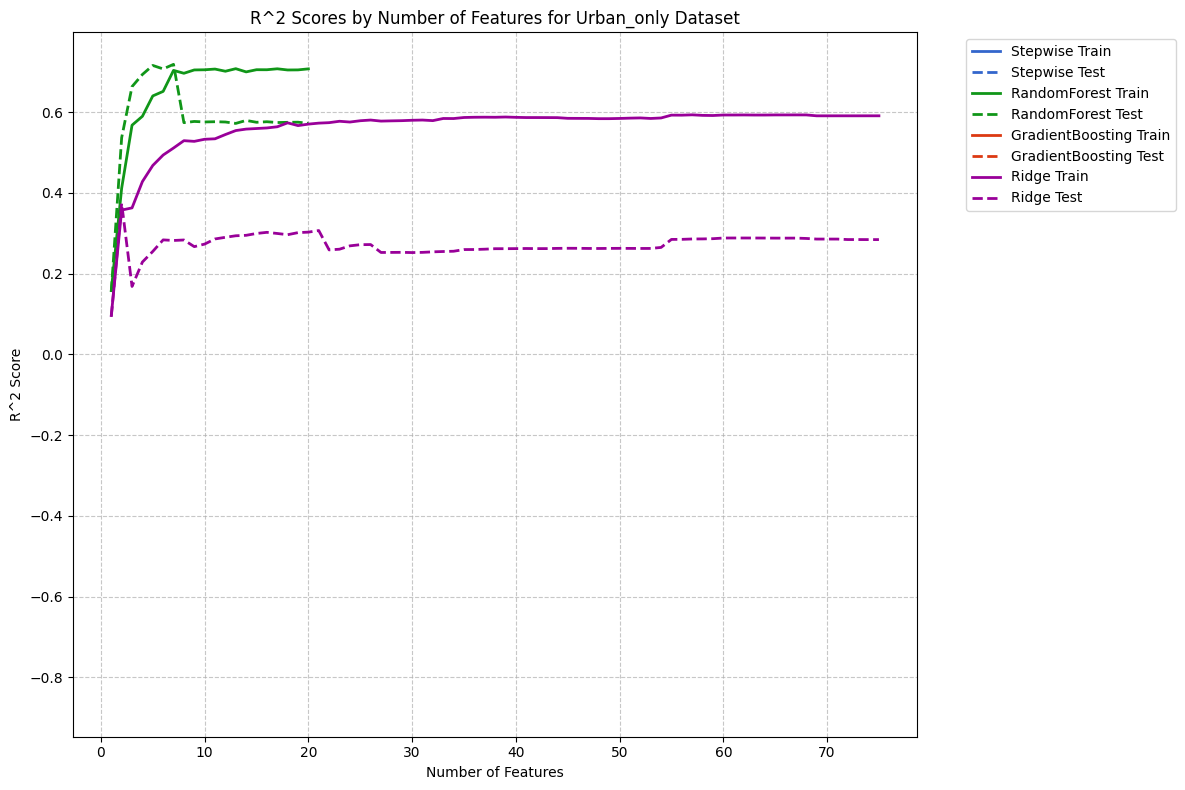

In [ ]:
make_r2_by_feature_count_plot("urban_only")

#### Urban Data

##### Ridge Regression

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_Ridge.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.535285,0.076233
1,spearman,0.698457,0.011878
2,pearson,0.743226,0.044099
3,recall_10,0.449396,0.029617
4,recall_20,0.538564,0.020075
5,recall_30,0.623209,0.016486
6,recall_40,0.694989,0.012325
7,recall_50,0.754648,0.008997
8,recall_60,0.814677,0.006514
9,recall_70,0.863348,0.005702


In [ ]:
    fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_Ridge.csv', index_col=0)
    fi

,Ridge FI
ag_asset_AXE,-0.000
ag_asset_BARN,-0.000
ag_asset_CHICKEN HOUSE,-0.000
ag_asset_FORK,-0.000
ag_asset_GENERATOR,0.000
ag_asset_GRAIN MILL,-0.000
ag_asset_GRANARY,-0.000
ag_asset_GRASS CUTTER,-0.000
ag_asset_HAMMER,-0.000
ag_asset_HAND HOE,-0.000


##### Random Forest


In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.517131,0.105521
1,spearman,0.707180,0.011327
2,pearson,0.740964,0.041594
3,recall_10,0.452943,0.027301
4,recall_20,0.562999,0.017846
5,recall_30,0.640531,0.012936
6,recall_40,0.702789,0.010171
7,recall_50,0.758677,0.009086
8,recall_60,0.811161,0.007167
9,recall_70,0.862210,0.005430


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_RandomForest.csv', index_col=0)
fi

,RandomForest FI
ag_asset_AXE,0.000
ag_asset_BARN,0.000
ag_asset_CHICKEN HOUSE,0.000
ag_asset_FORK,0.001
ag_asset_GENERATOR,0.000
ag_asset_GRAIN MILL,0.000
ag_asset_GRANARY,0.000
ag_asset_GRASS CUTTER,0.001
ag_asset_HAMMER,0.000
ag_asset_HAND HOE,0.000


##### Gradient Boosting

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.494234,0.129013
1,spearman,0.706961,0.011648
2,pearson,0.732344,0.044703
3,recall_10,0.458656,0.030716
4,recall_20,0.559252,0.019574
5,recall_30,0.640909,0.012316
6,recall_40,0.699545,0.010447
7,recall_50,0.758774,0.008294
8,recall_60,0.814393,0.007697
9,recall_70,0.863838,0.004833


In [ ]:
    fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_GradientBoosting.csv', index_col=0)
    fi

,GradientBoosting FI
ag_asset_AXE,0.000
ag_asset_BARN,0.000
ag_asset_CHICKEN HOUSE,0.000
ag_asset_FORK,0.000
ag_asset_GENERATOR,0.000
ag_asset_GRAIN MILL,0.000
ag_asset_GRANARY,0.000
ag_asset_GRASS CUTTER,0.000
ag_asset_HAMMER,0.000
ag_asset_HAND HOE,0.000


##### Stepwise OLS

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_Stepwise.csv', index_col=0)
df = summarize_bootstrap_results(df)
df


,Variable,Mean,Std Dev
0,r2,0.063022,0.398519
1,spearman,0.669852,0.131345
2,pearson,0.610206,0.100004
3,recall_10,0.358270,0.113609
4,recall_20,0.485200,0.112339
5,recall_30,0.590749,0.096053
6,recall_40,0.676645,0.086029
7,recall_50,0.748551,0.071910
8,recall_60,0.810232,0.062879
9,recall_70,0.863582,0.039897


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,4.057000e+00
durable_asset_Mortar/pestle (mtondo),6.077774e+06
hh_h03c,-4.600133e+06
hh_f09_SMOOTHED MUD,-5.690000e-01
durable_asset_Air conditioner,8.585417e+07
durable_asset_Washing machine,2.668423e+06
hh_h01_NO,3.430000e-01
hh_f19_YES,9.780000e-01
hh_t03_It was more than adequate for household needs,1.098000e+00
hh_head_education_5,1.249600e+01


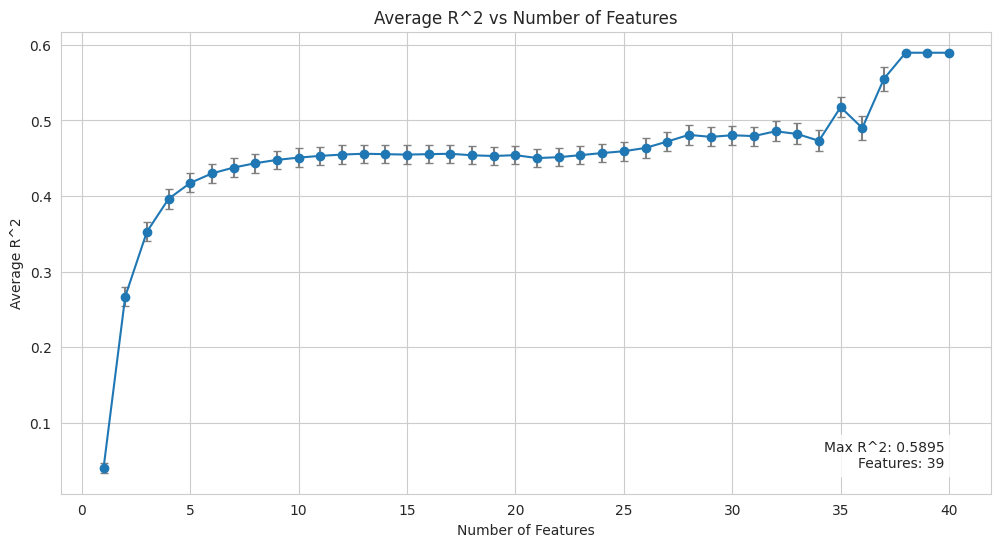

In [ ]:
r2_df = pd.read_csv('x02_ml_pipeline/output/urban_only/r2_Stepwise.csv', index_col=0)
make_r2_by_feature_count_plot(r2_df)

#### Rural Data


##### Ridge Regression


In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_Ridge.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.532644,0.071532
1,spearman,0.693278,0.012715
2,pearson,0.741032,0.042354
3,recall_10,0.443048,0.029694
4,recall_20,0.538360,0.021128
5,recall_30,0.619049,0.015608
6,recall_40,0.690123,0.011373
7,recall_50,0.752760,0.010100
8,recall_60,0.813049,0.007278
9,recall_70,0.862261,0.005513


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_Ridge.csv', index_col=0)
fi

,0
ag_asset_AXE,-2.447200e-03
ag_asset_BARN,-5.973112e-04
ag_asset_CHICKEN HOUSE,-4.313637e-04
ag_asset_FORK,-3.174932e-04
ag_asset_GENERATOR,-9.324165e-05
ag_asset_GRAIN MILL,-3.800024e-04
ag_asset_GRANARY,-6.399251e-05
ag_asset_GRASS CUTTER,-4.398536e-02
ag_asset_HAMMER,-1.481565e-03
ag_asset_HAND HOE,-6.536779e-05


##### Random Forest

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.124093,0.353802
1,spearman,0.698760,0.011853
2,pearson,0.689353,0.044860
3,recall_10,0.425686,0.037013
4,recall_20,0.551514,0.020319
5,recall_30,0.638875,0.015338
6,recall_40,0.698372,0.011809
7,recall_50,0.754132,0.009045
8,recall_60,0.807289,0.008487
9,recall_70,0.858598,0.006294


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_RandomForest.csv', index_col=0)
fi

,0
ag_asset_AXE,8.539984e-05
ag_asset_BARN,9.814701e-05
ag_asset_CHICKEN HOUSE,7.346683e-05
ag_asset_FORK,0.000000e+00
ag_asset_GENERATOR,3.946534e-06
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,3.349197e-04
ag_asset_HAMMER,1.654533e-04
ag_asset_HAND HOE,0.000000e+00


##### Gradient Boosting

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.027553,0.516298
1,spearman,0.698061,0.018395
2,pearson,0.667613,0.065879
3,recall_10,0.452535,0.050191
4,recall_20,0.553744,0.027744
5,recall_30,0.637810,0.019046
6,recall_40,0.697148,0.014165
7,recall_50,0.754186,0.010605
8,recall_60,0.811071,0.008759
9,recall_70,0.860027,0.008042


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_GradientBoosting.csv', index_col=0)
fi

,0
ag_asset_AXE,1.720521e-04
ag_asset_BARN,0.000000e+00
ag_asset_CHICKEN HOUSE,6.196176e-04
ag_asset_FORK,0.000000e+00
ag_asset_GENERATOR,0.000000e+00
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,0.000000e+00
ag_asset_HAMMER,0.000000e+00
ag_asset_HAND HOE,0.000000e+00


##### Stepwise OLS

In [ ]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_Stepwise.csv', index_col=0)
summarize_bootstrap_results(df)


,Variable,Mean,Std Dev
0,r2,0.059082,0.488632
1,spearman,0.630837,0.125606
2,pearson,0.594522,0.108646
3,recall_10,0.318978,0.107456
4,recall_20,0.452289,0.101059
5,recall_30,0.562054,0.092714
6,recall_40,0.650924,0.087770
7,recall_50,0.730708,0.064308
8,recall_60,0.798388,0.050756
9,recall_70,0.854535,0.035087


In [ ]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,3.421000e+00
durable_asset_Car,5.102243e+07
hh_f12_COLLECTED FIREWOOD,-7.500000e-01
hh_f36_PIPED INTO DWELLING,3.374000e+00
hh_h04_YES,-4.000000e-01
hh_f36_PIPED INTO YARD/PLOT,6.960000e-01
hh_f09_TILE,3.480000e+00
hh_t01_It was less than adequate for household needs,-3.660000e-01
hh_f10,-2.174452e+06
durable_asset_Television,-1.678158e+06


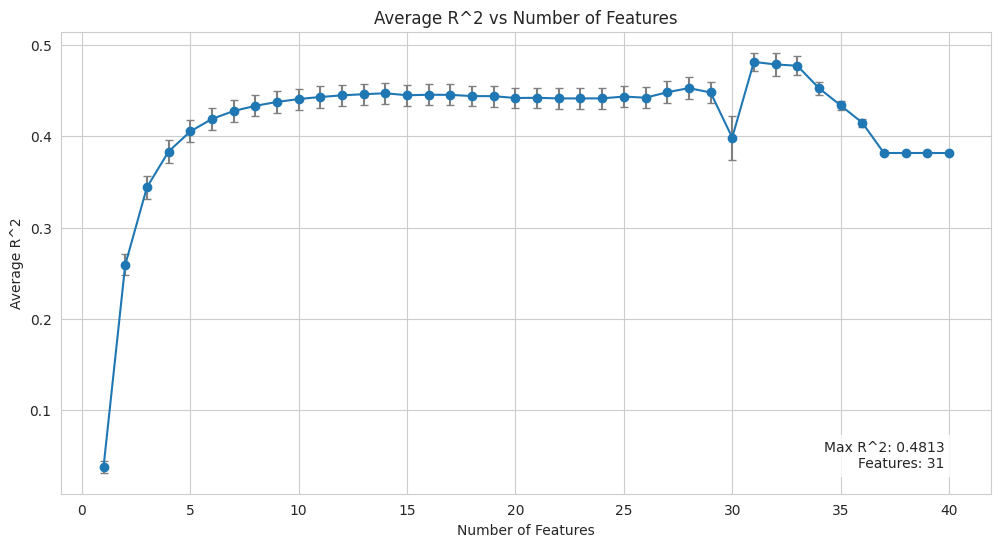

In [ ]:
r2_df = pd.read_csv('x02_ml_pipeline/output/rural_only/r2_Stepwise.csv', index_col=0)
make_r2_by_feature_count_plot(r2_df)